In [1]:
!pip install -q gwpy

In [1]:
%%capture
!pip install transformers
!pip install datasets
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd
import os
from datasets import load_dataset
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
%%capture
dataset = load_dataset("jxu9001/cs6301project50k")

In [6]:
print(dataset)
print(device)

DatasetDict({
    test: Dataset({
        features: ['image', 'expression', 'img_width', 'img_height', 'x', 'y', 'w', 'h'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['image', 'expression', 'img_width', 'img_height', 'x', 'y', 'w', 'h'],
        num_rows: 40000
    })
})
cuda


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_sample(row_num):
    sample = dataset['train'][row_num]
    print('Index:', row_num)
    print('Text:', sample['expression'])
    fig, ax = plt.subplots()
    rect = patches.Rectangle((sample['x'], sample['y']), sample['w'], sample['h'], linewidth=1, edgecolor='r', facecolor='none')
    ax.imshow(sample['image'])
    ax.add_patch(rect)


    

Index: 27586
Text: smallest blue octopus face


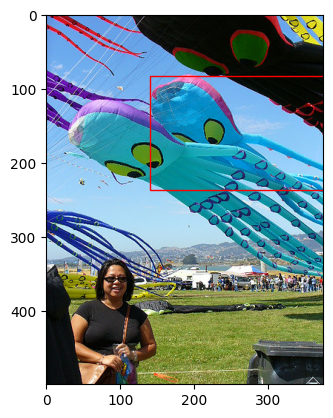

In [6]:
from random import randint
show_sample(randint(0, len(dataset['train'])))

In [8]:
def resize224(image_width, image_height, x, y , w, h):

    (origLeft, origTop, origRight, origBottom) = (x, y, x + w, y + h)

    return [origLeft/image_width, origTop/image_height, origRight/image_width, origBottom/image_height]

def ResNetTransform(image):
    img_size = 224
    mean, std = (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
    


    train_transform_func = transforms.Compose(
                [transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
                ])
    
    return train_transform_func(image)


bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


train_inputs = []
idx = 0
for sample in dataset['train']:
    

    if sample['image'].mode in ("RGB"):
        
        if idx % 5000 == 0:
            print("Training Preparation :", idx, " Completed")
        
        resized_coordinate = resize224(sample['img_width'], sample['img_height'], sample['x'], sample['y'], sample['w'], sample['h'])
        train_inputs.append(
            {
                'text': sample['expression'],
                'BBox': torch.tensor(resized_coordinate),
                'idx': idx
            }
        )
    
    idx += 1



test_inputs = []
idx = 0
for sample in dataset['test']:
    

    if sample['image'].mode in ("RGB"):
        
        if idx % 5000 == 0:
            print("Testing Preparation :", idx, " Completed")
        
        resized_coordinate = resize224(sample['img_width'], sample['img_height'], sample['x'], sample['y'], sample['w'], sample['h'])
        test_inputs.append(
            {
                'text': sample['expression'],
                'BBox': torch.tensor(resized_coordinate),
                'idx': idx
            }
        )
        

    idx += 1

print("Training & Testing Preparation Completed")    


Training Preparation : 0  Completed
Training Preparation : 5000  Completed
Training Preparation : 10000  Completed
Training Preparation : 15000  Completed
Training Preparation : 20000  Completed
Training Preparation : 25000  Completed
Training Preparation : 30000  Completed
Training Preparation : 35000  Completed
Testing Preparation : 0  Completed
Testing Preparation : 5000  Completed
Training & Testing Preparation Completed


In [9]:
train_dataloader = DataLoader(train_inputs, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_inputs, batch_size=100, shuffle=True)

In [10]:
import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)

        
    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [11]:
class RECEncoder(nn.Module):
    
    def __init__(self, n = 2, nhead = 8, hidden_dim = 768):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.nhead = nhead
        self.n = n
        self.text_encoder = AutoModel.from_pretrained('bert-base-uncased')
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048        
        self.hidden_layer_1 = nn.Linear(self.image_hidden_size, 768)
        
        self.text_attentions = nn.ModuleList()
        self.text_FFNNs = nn.ModuleList()
        self.text_norms1 = nn.ModuleList()
        self.text_norms2 = nn.ModuleList()
        
        self.visual_attentions = nn.ModuleList()
        self.visual_FFNNs = nn.ModuleList()
        self.visual_norms1 = nn.ModuleList()
        self.visual_norms2 = nn.ModuleList()
        self.dropout = nn.Dropout(0.1)
        
        
        for i in range(self.n):
            
            self.text_attentions.append(nn.MultiheadAttention(self.hidden_dim, self.nhead, 0.1))
            self.text_norms1.append(nn.LayerNorm(self.hidden_dim))  
            self.text_FFNNs.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.text_norms2.append(nn.LayerNorm(self.hidden_dim))  
            
            self.visual_attentions.append(nn.MultiheadAttention(self.hidden_dim, self.nhead, 0.1))
            self.visual_norms1.append(nn.LayerNorm(self.hidden_dim))  
            self.visual_FFNNs.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.visual_norms2.append(nn.LayerNorm(self.hidden_dim))  
                 

        
    def forward(self, image, expr):

        text_output = self.text_encoder(**expr)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.hidden_layer_1(self.visual_encoder(image))
        
        for text_attention, tFFNN, tnorm1, tnorm2, visual_attention, vFFNN, vnorm1, vnorm2 in zip(self.text_attentions, self.text_FFNNs, self.text_norms1, self.text_norms2, self.visual_attentions, self.visual_FFNNs, self.visual_norms1, self.visual_norms2):
            
            attn_output, _ = text_attention(text_feature, text_feature, text_feature)
            attn_output = tnorm1(text_feature + self.dropout(attn_output))
            text_feature = tnorm2(self.dropout(tFFNN(attn_output)) + attn_output)
            
            
            visual_attn_output, _ = visual_attention(img_feature, text_feature, text_feature)
            visual_attn_output = vnorm1(img_feature + self.dropout(visual_attn_output))
            img_feature = vnorm2(self.dropout(vFFNN(visual_attn_output)) + visual_attn_output)
                        


        return img_feature, text_feature
    


            
        

In [12]:
class RECDecoder(nn.Module):
    
    def __init__(self, n = 2, nhead = 8, hidden_dim = 768):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        self.nhead = nhead
        self.n = n

        
        self.attentions = nn.ModuleList()
        self.EDattentions = nn.ModuleList()
        self.FFNNs = nn.ModuleList()
        self.norms1 = nn.ModuleList()
        self.norms2 = nn.ModuleList()
        self.norms3 = nn.ModuleList()

        self.dropout = nn.Dropout(0.1)
           
        for i in range(self.n):
            
            self.attentions.append(nn.MultiheadAttention(self.hidden_dim, self.nhead, 0.1))
            self.EDattentions.append(nn.MultiheadAttention(self.hidden_dim, self.nhead, 0.1))
            self.norms1.append(nn.LayerNorm(self.hidden_dim))  
            self.FFNNs.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.norms2.append(nn.LayerNorm(self.hidden_dim))  
            self.norms3.append(nn.LayerNorm(self.hidden_dim))  


        
    def forward(self, image, expr):

        
        for attention, EDattention, FFNN, norm1, norm2, norm3 in zip(self.attentions, self.EDattentions, self.FFNNs, self.norms1, self.norms2, self.norms3):
            
            attn_output, _ = attention(expr, expr, expr)
            attn_output = norm1(expr + self.dropout(attn_output))
            EDattn_output, _ = EDattention(attn_output, image, image)
            EDattn_output = norm2(attn_output + self.dropout(EDattn_output))
            expr = norm3(self.dropout(FFNN(EDattn_output)) + EDattn_output)

        return expr

In [13]:
class VLTF(nn.Module):
    
    def __init__(self, n = 3, nhead = 8, hidden_dim = 768):
        
        super().__init__()
        
        self.encoder = RECEncoder()
        self.decoder = RECDecoder()
        
        self.hidden_layer_1 = nn.Linear(768, 512)
        self.hidden_layer_2 = nn.Linear(512, 512)
        self.output_layer = nn.Linear(512, 4)
        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()


    def forward(self, image, expr):
        
        img_feature, text_feature = self.encoder(image, expr)
        vl_embeddings = self.decoder(img_feature, text_feature)
        
        hidden_1_output = self.act_1(self.hidden_layer_1(vl_embeddings))
        hidden_2_output = self.act_1(self.hidden_layer_2(hidden_1_output))
        output = self.act_2(self.output_layer(hidden_2_output))
        
        return output

In [15]:
def calculate_iou(pred_bbox, gt_bbox):
    x1p, y1p, x2p, y2p = pred_bbox
    x1g, y1g, x2g, y2g = gt_bbox
    
    pred_area = (x2p - x1p + 1) * (y2p - y1p + 1) 
    gt_area = (x2g - x1g + 1) * (y2g - y1g + 1)

    xx1 = max(x1p, x1g) 
    yy1 = max(y1p, y1g) 
    xx2 = min(x2p, x2g) 
    yy2 = min(y2p, y2g) 
    
    w = max(0.0, xx2 - xx1 + 1) 
    h = max(0.0, yy2 - yy1 + 1) 
    intersection = w * h 
    union = pred_area + gt_area - intersection
    
    return intersection / union

SMOOTH = 1e-6

def get_iou(bb1, bb2):



    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

 
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])


    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

def show_sample_bbox(row_num, pred_bbx, gt_bbx):
    sample = dataset['train'][row_num]
    print('Index:', row_num)
    print('Text:', sample['expression'])
    fig, ax = plt.subplots()
    rect1 = patches.Rectangle((gt_bbx[0] * sample['img_width'], gt_bbx[1] * sample['img_height'] ), (gt_bbx[2]-gt_bbx[0]) * sample['img_width'], (gt_bbx[3]-gt_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='r', facecolor='none')
    rect2 = patches.Rectangle((pred_bbx[0] * sample['img_width'], pred_bbx[1] * sample['img_height'] ), (pred_bbx[2]-pred_bbx[0]) * sample['img_width'], (pred_bbx[3]-pred_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='b', facecolor='none')
    ax.imshow(sample['image'])
    ax.add_patch(rect1)
    ax.add_patch(rect2)

In [16]:
import pandas as pd



vltf_model = VLTF().to(device)


num_train_epochs = 10
learning_rate = 1.0e-4
weight_decay = 0.001
warmup_steps = 0
max_seq_length = 64

train_IoU, test_IoU = [], []

criterion = nn.SmoothL1Loss(reduction = "sum")
optimizer = AdamW(vltf_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch_num in trange(num_train_epochs, desc='Epochs'):
    
    print("Epoch ", epoch_num)
    print("==================")
    
    epoch_total_loss = 0
    
    
    vltf_model.train()
    data_size = 0
    correct_bbox = 0
    
    for step, batch in enumerate(tqdm(train_dataloader)):      
        
        b_text = batch['text']
        b_BBox = batch['BBox'] 
        b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length,return_tensors="pt", padding =  "max_length").to(device)
        b_idx = batch['idx'].tolist()


        tmp = list()
        for idx in b_idx:
            b_img = ResNetTransform(dataset['train'][idx]['image'])
            tmp.append(b_img)
            
        b_imgs = torch.stack(tmp).to(device)
        
        
        vltf_model.zero_grad()        
        BBox_Predicted = vltf_model(b_imgs, b_inputs).cpu()
        

        
        for p, t, i in zip(BBox_Predicted.tolist(), b_BBox.tolist(), b_idx):
            IoU = get_iou(p, t)
    
            data_size += 1
            if IoU > 0.5:
                correct_bbox += 1
    


        loss = criterion(BBox_Predicted, b_BBox)
        epoch_total_loss += loss.item()

        loss.backward()
        optimizer.step()            
 

    print("Training Accuracy @ 0.5 : ", correct_bbox, data_size, correct_bbox / data_size)
    train_IoU.append(correct_bbox / data_size)
        
        
    vltf_model.eval()
    data_size = 0
    correct_bbox = 0
    
    for step, batch in enumerate(tqdm(test_dataloader)):      
        
        b_text = batch['text']
        b_BBox = batch['BBox'] 
        b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length,return_tensors="pt", padding =  "max_length").to(device)
        b_idx = batch['idx'].tolist()
        
        b_inputs = b_inputs.to(device)

        
        tmp = list()
        for idx in b_idx:
            b_img = ResNetTransform(dataset['test'][idx]['image'])
            tmp.append(b_img)
            
        b_imgs = torch.stack(tmp).to(device)
        
        
        with torch.no_grad():      
            BBox_Predicted = vltf_model(b_imgs, b_inputs).cpu()
        
        for p, t, i in zip(BBox_Predicted.tolist(), b_BBox.tolist(), b_idx):
            IoU = get_iou(p, t)

            data_size += 1
            if IoU > 0.5:
                correct_bbox += 1

        
    print("Testing Accuracy @ 0.5 : ", correct_bbox, data_size, correct_bbox / data_size)
    test_IoU.append(correct_bbox / data_size)
    print(BBox_Predicted)
    
    if epoch_num % 2 == 0 and epoch_num > 1:

        path_name = 'CS6301_Group10_REC_DeEnCoder_2Layers_epoch_50k_' + str(epoch_num) + '.pth'

        #torch.save(vltf_model.state_dict(), path_name)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  0


  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  236 5000 0.0472


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  35 500 0.07
tensor([[0.2156, 0.2707, 0.5513, 0.7721],
        [0.4344, 0.2340, 0.7717, 0.8412],
        [0.2461, 0.3310, 0.6988, 0.7526],
        [0.2198, 0.2302, 0.6178, 0.8340],
        [0.2444, 0.2862, 0.6627, 0.7467],
        [0.2589, 0.3140, 0.7053, 0.7538],
        [0.2256, 0.2660, 0.6645, 0.7707],
        [0.2760, 0.3560, 0.7258, 0.7477],
        [0.2329, 0.2766, 0.6589, 0.7508],
        [0.2597, 0.3618, 0.7194, 0.7588],
        [0.2878, 0.3298, 0.7187, 0.7287],
        [0.2851, 0.3743, 0.7269, 0.7452],
        [0.2518, 0.1802, 0.6341, 0.8662],
        [0.2278, 0.2362, 0.5245, 0.8026],
        [0.2828, 0.3744, 0.7285, 0.7527],
        [0.2522, 0.3667, 0.6993, 0.7553],
        [0.4721, 0.2661, 0.7846, 0.8258],
        [0.3048, 0.1725, 0.6597, 0.8726],
        [0.4705, 0.2346, 0.7771, 0.8474],
        [0.3036, 0.3372, 0.7457, 0.7401],
        [0.2424, 0.2959, 0.6614, 0.7443],
        [0.2656, 0.3349, 0.7116, 0.7402],
        [0.2467, 0.1911, 0.6215, 0.850

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  368 5000 0.0736


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  40 500 0.08
tensor([[0.2742, 0.2479, 0.7100, 0.8428],
        [0.2592, 0.2667, 0.7031, 0.8242],
        [0.2531, 0.2627, 0.7009, 0.8256],
        [0.1075, 0.3438, 0.3944, 0.8287],
        [0.2740, 0.3079, 0.7285, 0.7280],
        [0.1073, 0.3563, 0.3991, 0.8246],
        [0.2847, 0.2538, 0.7155, 0.8237],
        [0.2687, 0.2522, 0.7050, 0.8358],
        [0.2591, 0.3435, 0.7497, 0.7386],
        [0.2637, 0.3280, 0.7392, 0.7363],
        [0.2880, 0.2449, 0.7062, 0.8391],
        [0.2500, 0.3541, 0.7543, 0.7757],
        [0.2815, 0.2597, 0.7147, 0.8172],
        [0.2434, 0.3312, 0.7406, 0.7820],
        [0.2777, 0.3230, 0.7186, 0.6994],
        [0.2728, 0.2831, 0.7353, 0.7897],
        [0.2692, 0.2494, 0.6884, 0.8314],
        [0.5447, 0.2459, 0.8958, 0.8113],
        [0.2736, 0.2451, 0.6931, 0.8421],
        [0.3047, 0.2356, 0.7043, 0.8469],
        [0.2691, 0.3255, 0.7415, 0.7274],
        [0.1077, 0.3561, 0.3982, 0.8249],
        [0.2927, 0.2717, 0.7034, 0.766

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  424 5000 0.0848


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  44 500 0.088
tensor([[0.2948, 0.2658, 0.7090, 0.8246],
        [0.2915, 0.2013, 0.5968, 0.8242],
        [0.2588, 0.3294, 0.7195, 0.8689],
        [0.3504, 0.4629, 0.7659, 0.8823],
        [0.3593, 0.1790, 0.6369, 0.8781],
        [0.3239, 0.1992, 0.6698, 0.8812],
        [0.3117, 0.2375, 0.7058, 0.8931],
        [0.3051, 0.1942, 0.5773, 0.8727],
        [0.3263, 0.2162, 0.6558, 0.8851],
        [0.0979, 0.2273, 0.3764, 0.8325],
        [0.6136, 0.2372, 0.8746, 0.7228],
        [0.3470, 0.4851, 0.7358, 0.8681],
        [0.3010, 0.3047, 0.6968, 0.8571],
        [0.1890, 0.1835, 0.4829, 0.8284],
        [0.2841, 0.2269, 0.6518, 0.8753],
        [0.3456, 0.2644, 0.7502, 0.6988],
        [0.3191, 0.4586, 0.7514, 0.8806],
        [0.2888, 0.2215, 0.6286, 0.8552],
        [0.3052, 0.2736, 0.7123, 0.6515],
        [0.0994, 0.2157, 0.3809, 0.8171],
        [0.2719, 0.1955, 0.5967, 0.8806],
        [0.6101, 0.1986, 0.8628, 0.7621],
        [0.2646, 0.2518, 0.6870, 0.87

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  494 5000 0.0988


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  56 500 0.112
tensor([[0.1732, 0.2001, 0.5301, 0.5752],
        [0.0838, 0.2215, 0.3910, 0.7265],
        [0.2192, 0.3486, 0.7555, 0.7326],
        [0.6054, 0.2078, 0.9253, 0.8036],
        [0.6091, 0.2182, 0.9278, 0.8140],
        [0.2338, 0.2210, 0.6993, 0.8214],
        [0.3581, 0.4970, 0.7297, 0.7929],
        [0.2403, 0.1518, 0.6050, 0.8306],
        [0.1142, 0.1920, 0.4444, 0.7325],
        [0.2701, 0.2626, 0.7496, 0.6381],
        [0.3034, 0.3960, 0.8002, 0.7450],
        [0.1687, 0.1938, 0.5931, 0.7952],
        [0.2718, 0.4084, 0.7665, 0.7531],
        [0.3784, 0.1625, 0.7065, 0.8081],
        [0.2270, 0.1436, 0.6036, 0.8615],
        [0.3524, 0.4339, 0.8238, 0.7711],
        [0.3829, 0.5310, 0.8348, 0.8165],
        [0.0720, 0.1843, 0.3460, 0.8429],
        [0.4202, 0.3296, 0.8585, 0.7758],
        [0.2299, 0.1883, 0.7037, 0.8696],
        [0.3992, 0.4006, 0.8441, 0.6941],
        [0.3347, 0.1681, 0.6252, 0.8170],
        [0.2276, 0.4940, 0.7389, 0.87

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  682 5000 0.1364


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  60 500 0.12
tensor([[0.2589, 0.4702, 0.7472, 0.8893],
        [0.3427, 0.1732, 0.6480, 0.8433],
        [0.4226, 0.1677, 0.7337, 0.7923],
        [0.2994, 0.1806, 0.6390, 0.8790],
        [0.1988, 0.2691, 0.5460, 0.7807],
        [0.6214, 0.1712, 0.9152, 0.6306],
        [0.2729, 0.2246, 0.5868, 0.7540],
        [0.3996, 0.5290, 0.8705, 0.8995],
        [0.3906, 0.1573, 0.6723, 0.7444],
        [0.3697, 0.4376, 0.8136, 0.8744],
        [0.3480, 0.2567, 0.8287, 0.6775],
        [0.4326, 0.5048, 0.8342, 0.8667],
        [0.3618, 0.1629, 0.7148, 0.8599],
        [0.5781, 0.3020, 0.8858, 0.8554],
        [0.2422, 0.2433, 0.6679, 0.9162],
        [0.4776, 0.3612, 0.8599, 0.8166],
        [0.3476, 0.1673, 0.6746, 0.7708],
        [0.3217, 0.1641, 0.8270, 0.9096],
        [0.2634, 0.2047, 0.5845, 0.8500],
        [0.1560, 0.6158, 0.4800, 0.9195],
        [0.2490, 0.3737, 0.8254, 0.8908],
        [0.3286, 0.1696, 0.6973, 0.7805],
        [0.2476, 0.2128, 0.7071, 0.889

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  878 5000 0.1756


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  62 500 0.124
tensor([[0.2542, 0.1843, 0.8272, 0.9055],
        [0.6080, 0.2068, 0.9386, 0.8200],
        [0.1073, 0.6389, 0.5002, 0.9344],
        [0.5115, 0.4249, 0.8669, 0.9133],
        [0.5288, 0.2053, 0.8342, 0.8441],
        [0.2365, 0.2231, 0.8422, 0.6949],
        [0.3681, 0.1366, 0.8013, 0.8219],
        [0.2159, 0.1629, 0.7300, 0.8846],
        [0.5365, 0.3622, 0.8985, 0.8841],
        [0.4873, 0.4185, 0.8616, 0.7180],
        [0.2937, 0.6102, 0.6393, 0.9164],
        [0.0935, 0.6029, 0.5721, 0.9099],
        [0.0829, 0.1906, 0.4723, 0.7008],
        [0.2588, 0.1699, 0.7321, 0.9295],
        [0.3321, 0.2501, 0.6503, 0.8350],
        [0.4801, 0.1743, 0.7786, 0.8673],
        [0.6175, 0.2067, 0.9272, 0.9063],
        [0.6192, 0.1712, 0.9317, 0.8297],
        [0.4312, 0.1568, 0.7461, 0.8645],
        [0.3416, 0.1505, 0.6962, 0.8940],
        [0.4663, 0.1548, 0.8255, 0.8950],
        [0.2162, 0.2239, 0.5886, 0.9253],
        [0.2573, 0.1898, 0.7203, 0.93

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  1149 5000 0.2298


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  37 500 0.074
tensor([[0.6220, 0.4849, 0.8932, 0.8176],
        [0.0536, 0.1894, 0.2604, 0.8232],
        [0.0841, 0.2203, 0.3384, 0.9076],
        [0.1665, 0.1492, 0.5034, 0.9099],
        [0.5363, 0.4362, 0.9218, 0.8770],
        [0.2886, 0.1801, 0.6632, 0.9094],
        [0.4287, 0.2384, 0.7851, 0.8332],
        [0.6523, 0.1689, 0.9212, 0.7087],
        [0.2725, 0.2590, 0.6771, 0.9321],
        [0.2037, 0.2259, 0.4854, 0.8994],
        [0.1631, 0.4170, 0.4854, 0.7933],
        [0.2752, 0.3934, 0.8308, 0.8978],
        [0.3229, 0.3331, 0.5144, 0.7846],
        [0.3618, 0.5740, 0.7575, 0.9382],
        [0.1821, 0.2536, 0.5534, 0.8603],
        [0.1879, 0.2539, 0.8506, 0.9239],
        [0.2917, 0.4092, 0.4941, 0.8272],
        [0.2691, 0.4098, 0.5332, 0.8253],
        [0.4938, 0.2075, 0.7845, 0.8787],
        [0.1452, 0.3243, 0.3738, 0.7077],
        [0.0690, 0.2138, 0.3372, 0.8651],
        [0.5630, 0.2178, 0.8100, 0.5427],
        [0.0848, 0.2061, 0.3218, 0.76

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  1442 5000 0.2884


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  53 500 0.106
tensor([[0.0983, 0.0518, 0.3606, 0.4404],
        [0.4073, 0.5439, 0.9387, 0.9078],
        [0.6034, 0.2481, 0.9211, 0.6216],
        [0.0680, 0.1191, 0.6547, 0.8956],
        [0.3476, 0.2535, 0.5690, 0.7636],
        [0.0593, 0.5304, 0.4742, 0.8839],
        [0.3574, 0.4478, 0.6920, 0.9004],
        [0.2505, 0.1540, 0.5515, 0.8640],
        [0.3622, 0.2100, 0.5995, 0.8716],
        [0.5722, 0.4390, 0.8676, 0.9534],
        [0.1016, 0.1632, 0.3578, 0.8089],
        [0.4928, 0.2733, 0.8685, 0.7733],
        [0.3871, 0.6517, 0.9303, 0.9323],
        [0.3322, 0.2105, 0.5681, 0.7606],
        [0.3165, 0.5039, 0.6190, 0.8662],
        [0.6052, 0.3602, 0.9645, 0.9037],
        [0.5119, 0.5091, 0.8715, 0.7931],
        [0.1980, 0.3832, 0.4906, 0.7388],
        [0.1008, 0.1878, 0.3851, 0.9073],
        [0.3134, 0.3229, 0.5582, 0.7806],
        [0.4083, 0.4899, 0.9057, 0.8511],
        [0.3385, 0.4405, 0.7181, 0.8084],
        [0.4871, 0.1407, 0.9446, 0.66

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  1793 5000 0.3586


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  54 500 0.108
tensor([[0.3903, 0.3779, 0.6611, 0.9151],
        [0.2888, 0.1732, 0.6584, 0.8320],
        [0.0334, 0.2222, 0.3022, 0.9210],
        [0.1792, 0.3713, 0.5026, 0.6631],
        [0.2591, 0.1441, 0.9271, 0.7313],
        [0.0775, 0.1294, 0.3156, 0.4373],
        [0.2225, 0.0965, 0.8842, 0.6951],
        [0.2960, 0.4051, 0.5594, 0.8262],
        [0.6297, 0.6192, 0.9471, 0.9623],
        [0.2434, 0.1788, 0.8398, 0.5325],
        [0.0547, 0.6492, 0.6637, 0.9353],
        [0.4783, 0.2395, 0.6700, 0.6725],
        [0.1091, 0.4144, 0.8346, 0.8426],
        [0.3403, 0.2437, 0.5508, 0.8496],
        [0.1218, 0.6288, 0.5786, 0.9202],
        [0.5497, 0.1966, 0.6792, 0.6387],
        [0.1490, 0.2170, 0.4057, 0.9247],
        [0.4741, 0.5519, 0.7858, 0.9658],
        [0.2907, 0.2241, 0.5859, 0.9068],
        [0.0871, 0.4068, 0.7138, 0.8904],
        [0.0557, 0.4892, 0.4188, 0.7970],
        [0.3112, 0.4762, 0.5997, 0.8907],
        [0.1231, 0.5342, 0.8608, 0.84

  0%|          | 0/50 [00:00<?, ?it/s]

Training Accuracy @ 0.5 :  2086 5000 0.4172


  0%|          | 0/5 [00:00<?, ?it/s]

Testing Accuracy @ 0.5 :  50 500 0.1
tensor([[0.1039, 0.3633, 0.3367, 0.8214],
        [0.4576, 0.2907, 0.8602, 0.5978],
        [0.2636, 0.3377, 0.6426, 0.8290],
        [0.1810, 0.1803, 0.6142, 0.7745],
        [0.0429, 0.0704, 0.5197, 0.9220],
        [0.6494, 0.0762, 0.8115, 0.6093],
        [0.3308, 0.0810, 0.8615, 0.9146],
        [0.1387, 0.1196, 0.3433, 0.4697],
        [0.2795, 0.4125, 0.4656, 0.8259],
        [0.0948, 0.5964, 0.3207, 0.9456],
        [0.0738, 0.6826, 0.6847, 0.9684],
        [0.3507, 0.2781, 0.6000, 0.8804],
        [0.2869, 0.5260, 0.7480, 0.9341],
        [0.1687, 0.1295, 0.8627, 0.9625],
        [0.0432, 0.6658, 0.4455, 0.9660],
        [0.2882, 0.5992, 0.5392, 0.8566],
        [0.4169, 0.1532, 0.9004, 0.9607],
        [0.2736, 0.4237, 0.3525, 0.8450],
        [0.7040, 0.1949, 0.9466, 0.9298],
        [0.1593, 0.1765, 0.5435, 0.9448],
        [0.2746, 0.5481, 0.8017, 0.8747],
        [0.0944, 0.5444, 0.6339, 0.9095],
        [0.0764, 0.1277, 0.5424, 0.9207

In [17]:
import pandas as pd

x = pd.DataFrame({'train': train_IoU, 'test': test_IoU})
x.to_csv("CS6301_Group10_REC_TFModel_6Layers_IoUR2.csv")


In [ ]:
vltf_model = BertResNetModel(text_pretrained='bert-base-uncased')
vltf_model.load_state_dict(torch.load('CS6301_Group10_REC_TFModel_6Layers_epoch_9.pth'))

[0.57865846 0.32951772 0.8443593  0.82033443] [0.8269062500000001, 0.36142857142857143, 0.990375, 0.7162763466042155]
Index: 272
Text: chair at 3 o clock of laptop


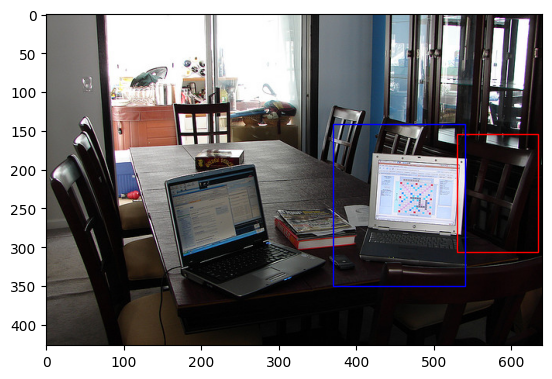

In [51]:
from random import randint

def show_sample_bbox(df, row_num, pred_bbx, gt_bbx):
    sample = df[row_num]
    print('Index:', row_num)
    print('Text:', sample['expression'])
    fig, ax = plt.subplots()
    rect1 = patches.Rectangle((gt_bbx[0] * sample['img_width'], gt_bbx[1] * sample['img_height'] ), (gt_bbx[2]-gt_bbx[0]) * sample['img_width'], (gt_bbx[3]-gt_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='r', facecolor='none')
    rect2 = patches.Rectangle((pred_bbx[0] * sample['img_width'], pred_bbx[1] * sample['img_height'] ), (pred_bbx[2]-pred_bbx[0]) * sample['img_width'], (pred_bbx[3]-pred_bbx[1]) * sample['img_height'], linewidth=1, edgecolor='b', facecolor='none')
    ax.imshow(sample['image'])
    ax.add_patch(rect1)
    ax.add_patch(rect2)

    

sample_idx = randint(0, 500)
df = dataset['train']
text_input = df[sample_idx]['expression']
image_input = ResNetTransform(df[sample_idx]['image'])
Actual_BBox = resize224(df[sample_idx]['img_width'], df[sample_idx]['img_height'], df[sample_idx]['x'], df[sample_idx]['y'], df[sample_idx]['w'], df[sample_idx]['h'])



vltf_model.eval()

b_BBox = Actual_BBox
b_inputs = bert_tokenizer(text_input, truncation=True, max_length=60,return_tensors="pt", padding =  "max_length")

b_imgs = image_input[None, :].to(device)
b_inputs = b_inputs.to(device)



with torch.no_grad():      
    BBox_Predicted = vltf_model(b_imgs, b_inputs).cpu()
    
print(BBox_Predicted.numpy()[0], Actual_BBox)

show_sample_bbox(df, sample_idx, BBox_Predicted.numpy()[0], Actual_BBox)
